In [23]:
from __future__ import print_function

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from datetime import datetime
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import keras.backend as K
from keras.wrappers.scikit_learn import KerasClassifier

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

In [24]:
def plot_decision_boundary(func, X, y, figsize=(9, 6)):
    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)
    
    aa, bb = np.meshgrid(hticks, vticks)
    ab = np.c_[aa.ravel(), bb.ravel()]
    c = func(ab)
    cc = c.reshape(aa.shape)

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    fig, ax = plt.subplots(figsize=figsize)
    contour = plt.contourf(aa, bb, cc, cmap=cm, alpha=0.8)
    
    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])
    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.xlim(amin, amax)
    plt.ylim(bmin, bmax)

def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    Z = model.predict_classes(np.c_[xx.ravel(), yy.ravel()], verbose=0)
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
def plot_data(X, y, figsize=None):
    if not figsize:
        figsize = (8, 6)
    plt.figure(figsize=figsize)
    plt.plot(X[y==0, 0], X[y==0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y==1, 0], X[y==1, 1], 'ob', alpha=0.5, label=1)
    plt.xlim((min(X[:, 0])-0.1, max(X[:, 0])+0.1))
    plt.ylim((min(X[:, 1])-0.1, max(X[:, 1])+0.1))
    plt.legend()

def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['acc'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_confusion_matrix(model, X, y):
    y_pred = model.predict_classes(X, verbose=0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    min_epoch = len(history_list[0].epoch)
    losses = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))
        min_epoch = min(min_epoch, len(history.epoch))
        losses.append(h['loss'][-1])

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Training Loss: " + ' vs '.join([str(round(x, 3)) for x in losses]))
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")
    
    plt.xlim(0, min_epoch-1)
    plt.tight_layout()
    
def make_sine_wave():
    c = 3
    num = 2400
    step = num/(c*4)
    np.random.seed(0)
    x0 = np.linspace(-c*np.pi, c*np.pi, num)
    x1 = np.sin(x0)
    noise = np.random.normal(0, 0.1, num) + 0.1
    noise = np.sign(x1) * np.abs(noise)
    x1  = x1 + noise
    x0 = x0 + (np.asarray(range(num)) / step) * 0.3
    X = np.column_stack((x0, x1))
    y = np.asarray([int((i/step)%2==1) for i in range(len(x0))])
    return X, y

def make_multiclass(N=500, D=2, K=3):
    np.random.seed(0)
    X = np.zeros((N*K, D))
    y = np.zeros(N*K)
    for j in range(K):
        ix = range(N*j, N*(j+1))
        # radius
        r = np.linspace(0.0,1,N)
        # theta
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, alpha=0.8)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    return X, y


In [25]:
rawdf = pd.read_csv('SampleECG.csv')
rawdf.head()


,24BITB,24BITC,24BITD,RL24BITCAL
0,-0.07,-0.56,-1.50,-2.90
1,-0.07,-0.56,-1.50,-2.89
2,-0.06,-0.56,-1.49,-2.88
3,-0.06,-0.56,-1.50,-3.04
4,-0.07,-0.56,-1.49,-3.05


In [26]:
rawdf.info()
(rawdf['24BITB'].value_counts())/rawdf['24BITB'].count()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120798 entries, 0 to 120797
Data columns (total 4 columns):
24BITB        120798 non-null float64
24BITC        120798 non-null float64
24BITD        120798 non-null float64
RL24BITCAL    120798 non-null float64
dtypes: float64(4)
memory usage: 3.7 MB


-0.06   0.01
-0.06   0.01
-0.06   0.01
-0.06   0.01
-0.07   0.01
-0.06   0.01
-0.06   0.01
-0.07   0.01
-0.07   0.01
-0.06   0.01
-0.06   0.01
-0.06   0.01
-0.07   0.01
-0.07   0.01
-0.06   0.01
-0.07   0.01
-0.06   0.01
-0.07   0.01
-0.07   0.01
-0.07   0.01
-0.06   0.01
-0.07   0.01
-0.06   0.01
-0.07   0.01
-0.07   0.01
-0.06   0.01
-0.07   0.01
-0.07   0.01
-0.07   0.01
-0.06   0.01
-0.07   0.01
-0.07   0.01
-0.07   0.00
-0.07   0.00
-0.07   0.00
-0.06   0.00
-0.07   0.00
-0.07   0.00
-0.08   0.00
-0.07   0.00
-0.07   0.00
-0.07   0.00
-0.07   0.00
-0.08   0.00
-0.10   0.00
-0.07   0.00
-0.10   0.00
-0.10   0.00
-0.10   0.00
-0.09   0.00
        ... 
0.17    0.00
0.44    0.00
0.20    0.00
-0.17   0.00
0.20    0.00
0.27    0.00
0.44    0.00
0.34    0.00
0.24    0.00
0.34    0.00
0.23    0.00
0.24    0.00
0.33    0.00
0.16    0.00
0.17    0.00
0.22    0.00
0.32    0.00
0.32    0.00
0.29    0.00
0.26    0.00
0.25    0.00
0.32    0.00
0.28    0.00
0.20    0.00
0.34    0.00
0.26    0.00

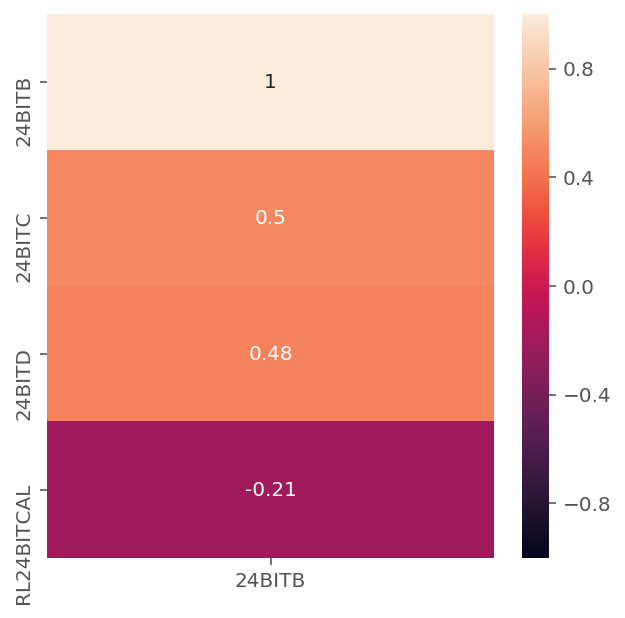

In [27]:
plt.figure(figsize=(5, 5))
sns.heatmap(rawdf.corr()[['24BITB']], annot=True, vmin=-1, vmax=1)

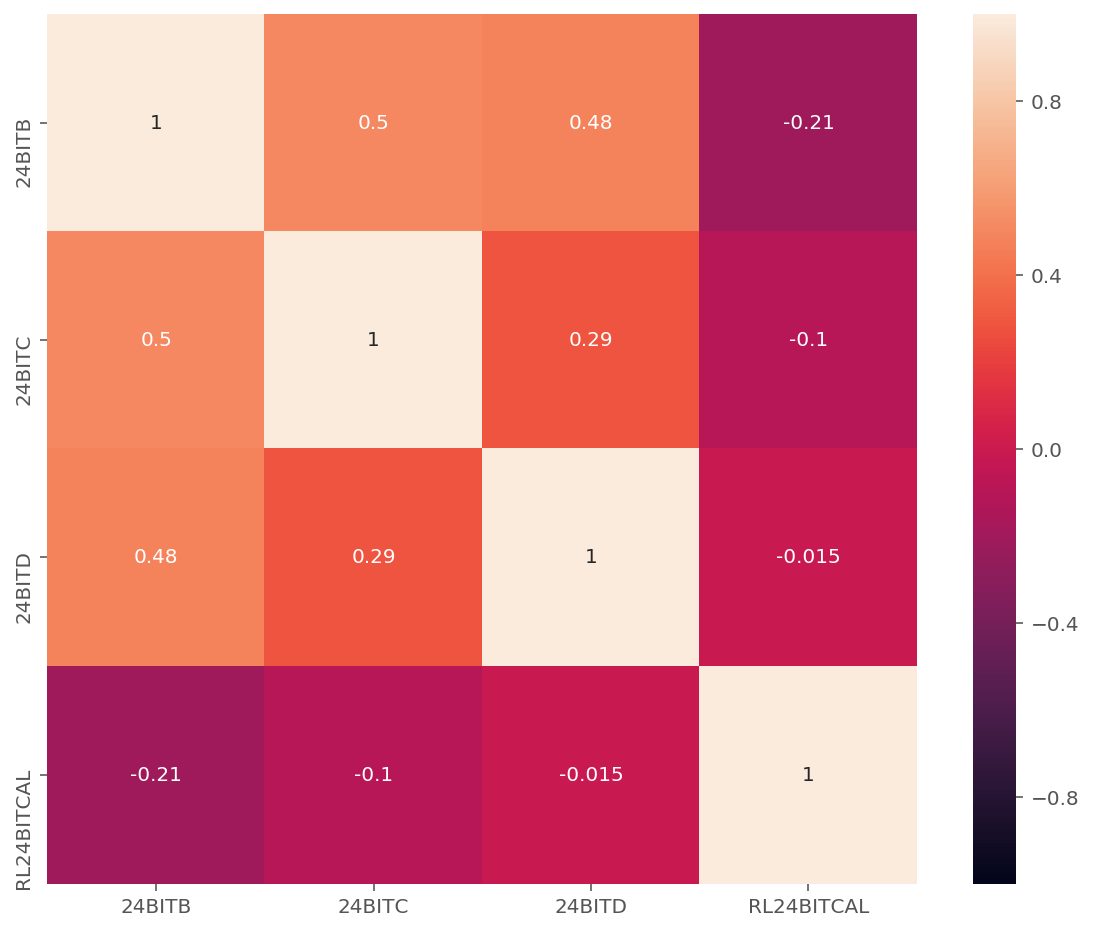

In [28]:
plt.figure(figsize=(10, 8))
sns.heatmap(rawdf.corr(), annot=True, square=True, vmin=-1, vmax=1)


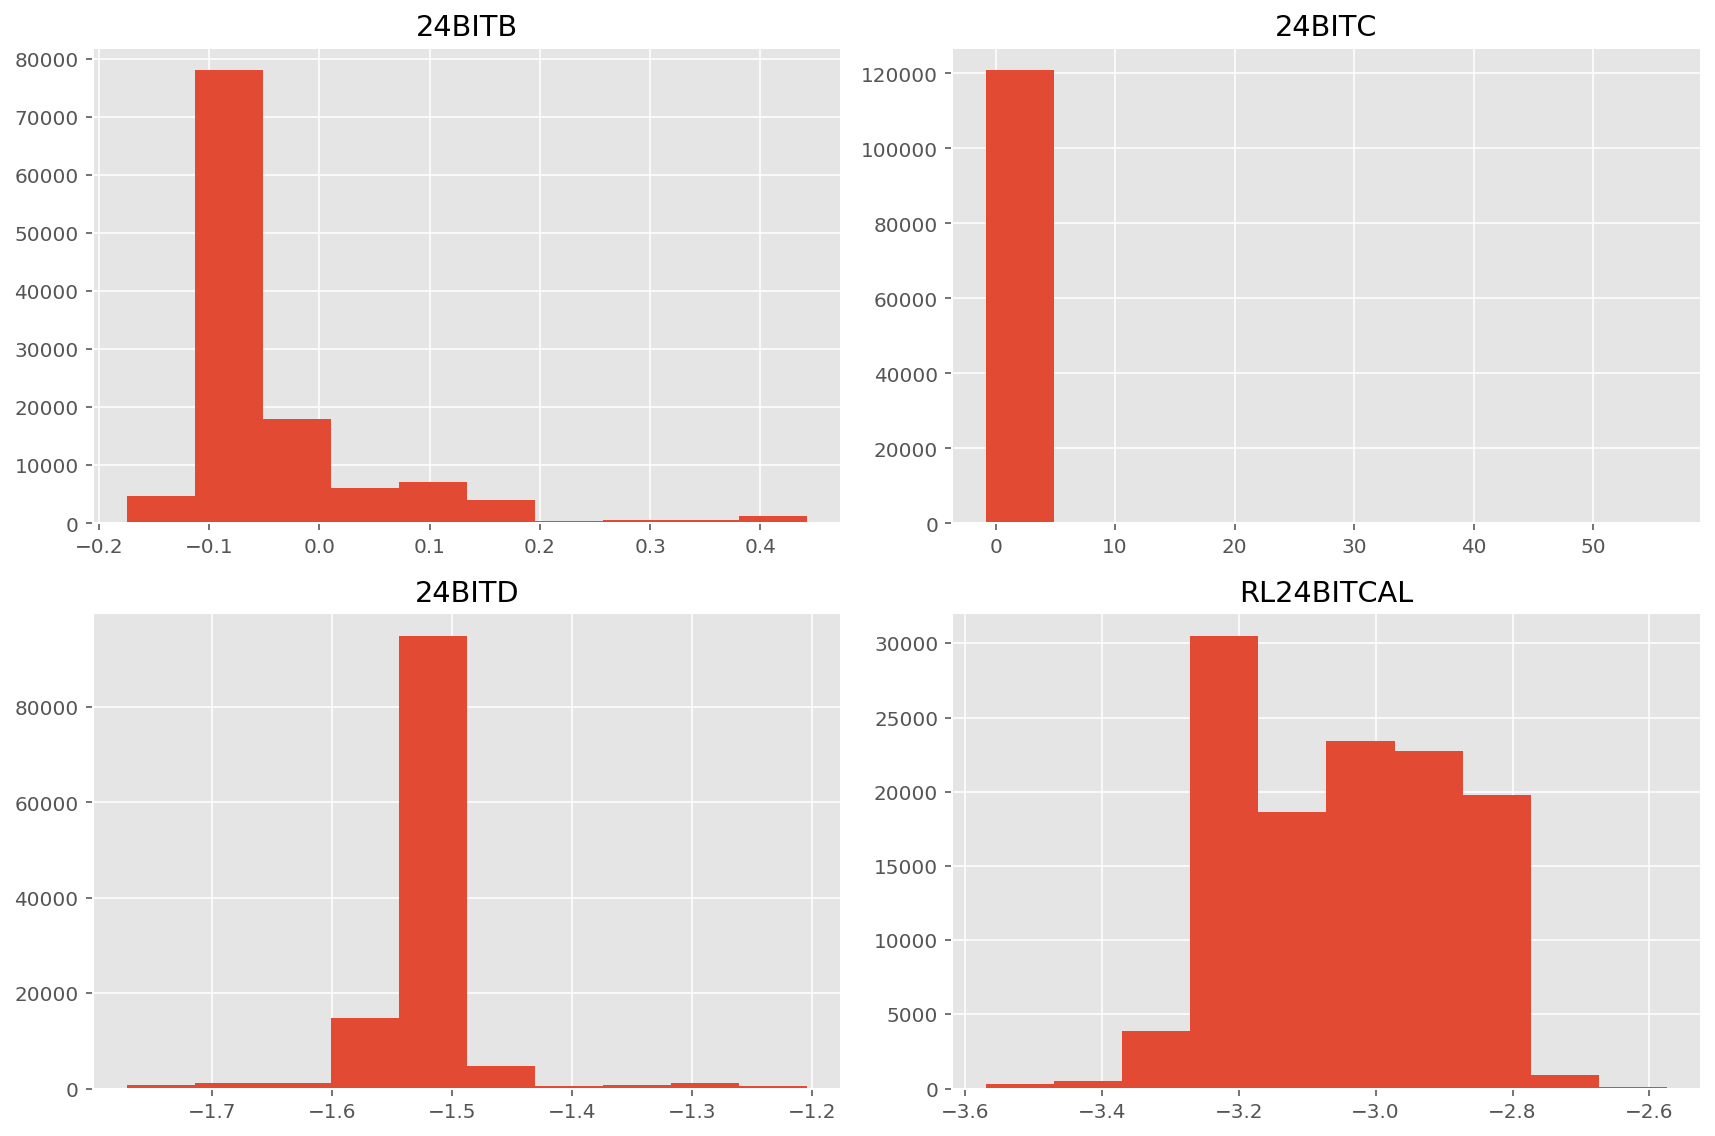

In [29]:
rawdf.hist(figsize=(12, 8))
plt.style.use('ggplot')
plt.tight_layout()

In [30]:
df = rawdf.copy()
ss = StandardScaler()
scale_features = ['24BITB', '24BITC', '24BITD']
df[scale_features] = ss.fit_transform(df[scale_features])

categorical_features = ['RL24BITCAL', 'RL24BITCAL']
df_cat = pd.get_dummies(df[categorical_features])
df = df.drop(categorical_features, axis=1)
df = pd.concat([df, df_cat], axis=1)
df.head()

,24BITB,24BITC,24BITD,RL24BITCAL,RL24BITCAL
0,-0.32,-0.17,0.45,-2.90,-2.90
1,-0.32,-0.17,0.39,-2.89,-2.89
2,-0.31,-0.15,0.63,-2.88,-2.88
3,-0.31,-0.17,0.44,-3.04,-3.04
4,-0.33,-0.17,0.58,-3.05,-3.05


In [31]:
df.filter(regex=("RL24BITCAL.*")).head()

,RL24BITCAL,RL24BITCAL
0,-2.90,-2.90
1,-2.89,-2.89
2,-2.88,-2.88
3,-3.04,-3.04
4,-3.05,-3.05


In [32]:
df.describe()

,24BITB,24BITC,24BITD,RL24BITCAL,RL24BITCAL
count,"120,798.00","120,798.00","120,798.00","120,798.00","120,798.00"
mean,-0.00,-0.00,-0.00,-3.05,-3.05
std,1.00,1.00,1.00,0.15,0.15
min,-1.55,-0.85,-5.31,-3.57,-3.57
25%,-0.51,-0.26,-0.30,-3.19,-3.19
50%,-0.31,-0.16,0.01,-3.05,-3.05
75%,0.08,0.06,0.28,-2.90,-2.90
max,5.42,172.23,6.70,-2.57,-2.57


In [33]:
X = df.drop('24BITB', axis=1).values
y = df['24BITB'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(84558, 4) (84558,) (36240, 4) (36240,)


In [ ]:
lr_model = Sequential()
lr_model.add(Dense(1, input_shape=(X_train.shape[1],), activation='sigmoid'))

lr_model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

lr_history = lr_model.fit(X_train, y_train, verbose=0, epochs=30)
plot_loss_accuracy(lr_history)

In [ ]:
y_pred = lr_model.predict_classes(X_test, verbose=0)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(lr_model, X_test, y_test)

In [ ]:
def get_model():
    lr_model = Sequential()
    lr_model.add(Dense(1, input_shape=(X_train.shape[1],), activation='sigmoid'))
    lr_model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])
    return lr_model

new_X, new_y = shuffle(X, y, random_state=0)
model = KerasClassifier(build_fn=get_model, epochs=5, verbose=0)
scores = cross_val_score(model, new_X, new_y, cv=5)
print(scores)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*scores.mean(), 100*scores.std()*2))

In [ ]:
deep_model = Sequential()
deep_model.add(Dense(64, input_shape=(X_train.shape[1],), activation='tanh'))
deep_model.add(Dense(16, activation='tanh'))
deep_model.add(Dense(1, activation='sigmoid'))

deep_model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

deep_history = deep_model.fit(X_train, y_train, verbose=0, epochs=30)
plot_loss_accuracy(deep_history)

In [ ]:
plot_compare_histories([lr_history, deep_history], ['Logistic Reg', 'Deep ANN'])

In [ ]:
y_pred = deep_model.predict_classes(X_test, verbose=0)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(deep_model, X_test, y_test)


In [ ]:
def get_model():
    return deep_model

model = KerasClassifier(build_fn=get_model, epochs=5, verbose=0)
scores = cross_val_score(model, X, y, cv=5)
print(scores)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*scores.mean(), 100*scores.std()*2))

In [ ]:
deep_model_vis = Sequential()
deep_model_vis.add(Dense(64, input_shape=(X_train.shape[1],), activation='tanh'))
deep_model_vis.add(Dense(16, activation='tanh'))
deep_model_vis.add(Dense(2, activation='tanh'))
deep_model_vis.add(Dense(1, activation='sigmoid'))

deep_model_vis.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

history = deep_model_vis.fit(X_train, y_train, verbose=0, epochs=10)
plot_loss_accuracy(history)

In [ ]:
# input to 2-D mapping
inp1 = deep_model_vis.layers[0].input
out1 = deep_model_vis.layers[2].output
func1 = K.function([inp1], [out1])

# 2-D to score prediction
inp2 = deep_model_vis.layers[3].input
out2 = deep_model_vis.layers[3].output
func2 = K.function([inp2], [out2])

features = func1([X_test])[0]
plot_decision_boundary(lambda x: func2([x])[0], features, y_test)
plt.title('Test Data Separation')

In [ ]:
y_pred = deep_model_vis.predict_classes(X_test, verbose=0)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(deep_model_vis, X_test, y_test)

In [ ]:
deep_model_vis = Sequential()
deep_model_vis.add(Dense(64, input_shape=(X_train.shape[1],), activation='tanh'))
deep_model_vis.add(Dense(2, activation='tanh'))
deep_model_vis.add(Dense(8, activation='tanh'))
deep_model_vis.add(Dense(16, activation='tanh'))
deep_model_vis.add(Dense(1, activation='sigmoid'))

deep_model_vis.compile(Adam(lr=0.005), 'binary_crossentropy', metrics=['accuracy'])

history = deep_model_vis.fit(X_train, y_train, verbose=0, epochs=5)
plot_loss_accuracy(history)

# input to 2-D mapping
inp1 = deep_model_vis.layers[0].input
out1 = deep_model_vis.layers[1].output
func1 = K.function([inp1], [out1])

# 2-D to score prediction
inp2 = deep_model_vis.layers[2].input
out2 = deep_model_vis.layers[-1].output
func2 = K.function([inp2], [out2])

features = func1([X_test])[0]
plot_decision_boundary(lambda x: func2([x])[0], features, y_test)
plt.title('Test Data Separation')

In [ ]:
deeper_model = Sequential()
deeper_model.add(Dense(64, input_shape=(X_train.shape[1],), activation='tanh'))
deeper_model.add(Dense(64, activation='tanh'))
deeper_model.add(Dense(1, activation='sigmoid'))

deeper_model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

deeper_history = deeper_model.fit(X_train, y_train, verbose=1, epochs=10)
plot_loss_accuracy(deeper_history)

In [ ]:
y_pred = deep_model.predict_classes(X_test, verbose=0)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(deep_model, X_test, y_test)